In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
%matplotlib inline

In [2]:
22%15

7

In [3]:
L = 100 # Длина основания
H = 150 # Высота всей детали
RR = 70 # Радиус большой окружности

In [4]:
def split_border(nodes, n, closed_contour=False):
    result = np.array([])
    
    ln = nodes.shape[0]-1
    
    for i in range(nodes.shape[0]-1):
        res_xs = np.linspace(nodes[i,0], nodes[i+1,0], n)[:-1]
        res_ys = np.linspace(nodes[i,1], nodes[i+1,1], n)[:-1]
        result = np.append(result, np.hstack((np.array(res_xs).reshape(-1,1), np.array(res_ys).reshape(-1,1))))

    if not closed_contour and n:
        result = np.append(result, np.hstack((np.array(nodes[:,0][-1]).reshape(-1,1), np.array(nodes[:,1][-1]).reshape(-1,1))))
        
    return result.reshape(-1, 2)

In [5]:
def gen_arc(center, R, alpha1, alpha2, n):
    alpha1 = np.radians(np.linspace(alpha1, alpha2, n))

    x1 = R * np.cos(alpha1) + center[0]
    y1 = R * np.sin(alpha1) + center[1]
    
    return np.hstack((x1.reshape(-1, 1), y1.reshape(-1, 1)))

In [6]:
def len_poly(poly):
    return np.sum(np.linalg.norm(poly[:-1]-poly[1:], axis=1))

In [7]:
def calculate_upper_smaller_circle_y_and_touch_point(R, W, RR):
    """ VERY IMPORTANT FUNCTION. Calculations form Mathematica 11 :)"""
    RR_outer = RR + W # Outer big circle radius

    touch_point_x = ((2.*R + W)*RR_outer)/(2.* (R + RR_outer))
    touch_point_y = (300.* R**2 + 600.* R *RR_outer + 300.* RR_outer**2 - np.sqrt(RR_outer**2 *(R + RR_outer)**2 *(-W + 2.*RR_outer) *(4.* R + W + 2.* RR_outer)))/(2.* (R + RR_outer)**2)
    small_circle_center_y = (300.* R*RR_outer + 300.* RR_outer**2 - np.sqrt(RR_outer**2* (R + RR_outer)**2* (-W + 2.* RR_outer)* (4.* R + W + 2.* RR_outer)))/(2.* RR_outer* (R + RR_outer))
    
    return (touch_point_x, touch_point_y, small_circle_center_y)

In [8]:
NUMSPLITS = 20
CM_PER_SPLIT = 2
SPLITS_COEFF = 1./CM_PER_SPLIT

In [9]:
def circular_mask(inner, circ_center, radius, delta=0):
    """True for points outside the circle"""
    mask = np.sum(np.power(inner - circ_center, 2), axis=1) > np.power(radius+delta, 2)
    return mask

In [10]:
def rectangular_mask(inner, lower_end_pt, h, w, delta=0):
    """True for points outside the rectangle"""
    mask = (inner[:,0] >= lower_end_pt[0]+delta) & (inner[:,0] <= lower_end_pt[0]+w-delta) &\
           (inner[:,1] >= lower_end_pt[1]+delta) & (inner[:,1] <= lower_end_pt[1]+h-delta)
    return np.logical_not(mask)

In [11]:
def transition_mask_upper(inner, big_radius, big_circle_center, small_radius, 
                    small_circle_center_left, small_circle_center_right, lower_plane_y, width, delta=0):
    
    mask1 = circular_mask(inner, big_circle_center, big_radius+width, delta)
    mask2 = circular_mask(inner, small_circle_center_left, small_radius, delta)
    mask3 = circular_mask(inner, small_circle_center_right, small_radius, delta)
    mask4 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask5 = inner[:,1] > lower_plane_y
    
    return mask1 & mask2 & mask3 & mask4 & mask5

def transition_mask_lower(inner, small_circle_radius, small_circle_center_left, 
                          small_circle_center_right, lower_plane_y, upper_plane_y, delta=0):
    mask1 = circular_mask(inner, small_circle_center_left, small_circle_radius, delta)
    mask2 = circular_mask(inner, small_circle_center_right, small_circle_radius, delta)
    mask3 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask4 = (inner[:,1] > lower_plane_y) & (inner[:,1] < upper_plane_y)
    
    return mask1 & mask2 & mask3 & mask4

In [65]:
def construct_figure(W, R, cm_per_split=2):
    SPLITS_COEFF = 1./cm_per_split
    
    # ----> Constants
    L = 100 # Длина основания
    H = 150 # Высота всей детали
    RR = 70 # Радиус большой окружности
    
    touch_point_x, touch_point_y, small_circle_center_y = calculate_upper_smaller_circle_y_and_touch_point(R, W, RR)
    
    circ_big = np.array([0., 150])          # Inner and outer big circles
    circle_lr = np.array([W/2. + R, W + R]) # Low right circle center
    circle_ur = np.array([R + W/2., small_circle_center_y]) # Upper right circle center
    circle_ul = np.array([-1.*(R + W/2.), small_circle_center_y]) # Upper left circle center
    circle_ll = np.array([-1*(W/2. + R), W+R]) # Lower left circle center
    
    # Введем также константы для длин окружностей
    theta = np.rad2deg(np.arcsin(touch_point_x/(RR+W)))
    theta1 = np.rad2deg(np.arcsin((circle_ur[0]-touch_point_x)/R))
    upper_circle_len = (2.*np.pi*RR)/2.
    small_circles_len = (np.pi * R * (90. - theta))/180.
    lower_circles_len = (np.pi * (RR+W) * (90. - theta))/180.

    border_part1 = np.array([
        [-50, 0],
        [50, 0],
        [50, W],
        [W/2.+R, W]
    ], dtype=float)
    circ1 = gen_arc(circle_lr, R, 270, 180, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                                # because we have border points there
    border_part2 = np.array([
        [W/2., W+R],
        [W/2, circle_ur[1]]
    ], dtype=float)
    circ2 = gen_arc(circle_ur, R, 180, 90+theta1, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                               # because we have border and other arc points there
    circ3_alpha1 = theta
    circ3 = gen_arc(circ_big, RR+W, 270+circ3_alpha1, 360., int(lower_circles_len*SPLITS_COEFF))[:-1] # Except only last point because
                                                                            # we threw away last point of the previous arc

    border_part3 = np.array([
        [RR+W, H],
        [RR, H]
    ])

    circ4 = gen_arc(circ_big, RR, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]

    border_part4 = np.array([
        [-1.*RR, H],
        [-1*RR-W, H]
    ])

    circ5 = gen_arc(circ_big, RR+W, 180, 270-circ3_alpha1, int(lower_circles_len*SPLITS_COEFF))[1:-1]

    circ6 = gen_arc(circle_ul, R, 90-theta1, 0, int(small_circles_len*SPLITS_COEFF))[:-1]

    border_part5 = np.array([
        [-1*W/2., circle_ul[1]],
        [-1*W/2., W+R]
    ])

    circ7 = gen_arc(circle_ll, R, 360, 270, int(small_circles_len*SPLITS_COEFF))[1:-1]

    border_part6 = np.array([
        [-1*(W/2.+R), W],
        [-50, W],
        [-50, 0.]
    ])
    
    # ----> Split border
    # For border part1
    border_part1_sp_1 = split_border(border_part1[:2], int(L*SPLITS_COEFF))
    border_part1_sp_2 = split_border(border_part1[1:3], int(W*SPLITS_COEFF))
    border_part1_sp_3 = split_border(border_part1[2:], int((L/2. - R)*SPLITS_COEFF))
    border_part1_sp = np.vstack([border_part1_sp_1, border_part1_sp_2, border_part1_sp_3])

    border_part2_sp = split_border(border_part2, int((small_circle_center_y-W-R)*SPLITS_COEFF))
    border_part3_sp = split_border(border_part3, int(W*SPLITS_COEFF))
    border_part4_sp = split_border(border_part4, int(W*SPLITS_COEFF))
    border_part5_sp = split_border(border_part5, int((small_circle_center_y-W-R)*SPLITS_COEFF))

    # For border part6
    border_part6_sp_1 = split_border(border_part6[:2], int((L/2. - R)*SPLITS_COEFF))
    border_part6_sp_2 = split_border(border_part6[1:], int(W*SPLITS_COEFF))[:-1]
    border_part6_sp = np.vstack([border_part6_sp_1, border_part6_sp_2])
    
    border = np.vstack([border_part1_sp, circ1, border_part2_sp, circ2, circ3, border_part3_sp, circ4, border_part4_sp,
                circ5, circ6, border_part5_sp, circ7, border_part6_sp])
    
    # ----> Construct meshes
    delta_x=0.5
    delta_y=2

    res_tostack = [] # Will stack them
    # Mesh for upper part
    mesh_upper = []
    for i in np.linspace(0, W, int(W*SPLITS_COEFF)):
        arc = gen_arc(circ_big, RR+i, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]
        mesh_upper.append(arc)

    #arc_middle_fix = gen_arc(circ_big, RR+i, 270.+(theta-theta/3.), 270.-(theta-theta/3.), int((np.pi*(RR+W)*(2.*(theta-theta/3.)))/180.*SPLITS_COEFF))
    mesh_upper = mesh_upper[1:-1] # Throw away first and last arcs
    #mesh_upper.append(arc_middle_fix)
    mesh_upper = np.vstack(mesh_upper)
    
    res_tostack.append(mesh_upper)

    # Mesh inbetween
    mesh_inbetween = []
    for pt_circ_left, pt_circ_right in zip(circ6[::-1], circ2):
        start_stop = np.array([pt_circ_left, pt_circ_right])
        start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
        if np.any(start_stop_sp[:,1] > H-RR-W):
            break
        mesh_inbetween.append(start_stop_sp)
    mesh_inbetween = np.vstack(mesh_inbetween)
    
    res_tostack.append(mesh_inbetween)

    # Mesh for rectangular part between base and top
    mesh_inbetween1 = []
    for pt_bord_left, pt_bord_right in zip(border_part2_sp[::-1], border_part5_sp):
        start_stop = np.array([pt_bord_left, pt_bord_right])
        start_stop_sp = split_border(start_stop, int(W*SPLITS_COEFF))[1:-1]
        mesh_inbetween1.append(start_stop_sp)
    if len(mesh_inbetween1):
        mesh_inbetween1 = np.vstack(mesh_inbetween1)
        res_tostack.append(mesh_inbetween1)

    # Mesh for lower transition area
    mesh_inbetween2 = []
    for pt_circ_left, pt_circ_right in zip(circ1[::-1][:-1], circ7[:-1]):
        start_stop = np.array([pt_circ_left, pt_circ_right])
        start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
        mesh_inbetween2.append(start_stop_sp)
    mesh_inbetween2[-1][:,1] -= 2*SPLITS_COEFF
    if len(mesh_inbetween2):
        mesh_inbetween2 = np.vstack(mesh_inbetween2)
        res_tostack.append(mesh_inbetween2)

    # Mesh for lower rectangle
    mesh_lower = []
    border_to_copy = border_part1[:2].copy()
    for i in np.linspace(0., W, int(W*SPLITS_COEFF)):
        mesh_lower.append(split_border(border_to_copy+np.array([[0.,i],[0.,i]]), int(L*SPLITS_COEFF))[1:-1])
    mesh_lower = mesh_lower[1:-1]
    mesh_lower = np.vstack(mesh_lower)
    
    res_tostack.append(mesh_lower)
    inner = np.vstack(res_tostack)

    # ----> Masks for net
    #mask_delta = 1
    #
    # For inner points inside big and bigger upper circles
    #mask_big_circle = circular_mask(inner, circ_big, RR, delta=1)
    #mask_bigger_circle = circular_mask(inner, circ_big, RR+W, delta=1)
    #
    # For points inside transition areas and rectangle inbetween
    #transition1 = transition_mask_upper(inner, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W, delta=1)
    #transition2 = transition_mask_lower(inner, R, circle_ll, circle_lr, W, W+R, delta=1)
    #retangle_inbetween = rectangular_mask(inner, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W, 0.5)
    #
    # For points inside rectangular base
    #rectangle_base = rectangular_mask(inner, [-1*L/2., 0.], W, L, 0.5)
    #
    # Construct resulting points
    #inner_upper = inner[mask_big_circle & np.logical_not(mask_bigger_circle)]
    #inner_lower = inner[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    #inner_masked = np.vstack([inner_upper, inner_lower])
    
    inner_masked = inner
    
    Nodes = np.vstack((border, inner_masked))
    trng = scipy.spatial.Delaunay(Nodes)
    
    # ----> Masks for TRNG
    trng_vertices = Nodes[trng.simplices.copy()]
    trng_x_vertices = trng_vertices[:, :, 0]
    trng_y_vertices = trng_vertices[:, :, 1]

    trng_x_mean = np.mean(trng_x_vertices, axis=1)
    trng_y_mean = np.mean(trng_y_vertices, axis=1)

    trng_centers = np.hstack((trng_x_mean.reshape(-1, 1), trng_y_mean.reshape(-1, 1)))

    simplices = trng.simplices.copy()

    # For inner points inside big and bigger upper circles
    mask_big_circle = circular_mask(trng_centers, circ_big, RR)
    mask_bigger_circle = circular_mask(trng_centers, circ_big, RR+W)

    # For points inside transition areas and rectangle inbetween
    transition1 = transition_mask_upper(trng_centers, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W)
    transition2 = transition_mask_lower(trng_centers, R, circle_ll, circle_lr, W, W+R)
    retangle_inbetween = rectangular_mask(trng_centers, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W)

    # For points inside rectangular base
    rectangle_base = rectangular_mask(trng_centers, [-1*L/2., 0.], W, L)

    simplices1 = simplices[mask_big_circle & np.logical_not(mask_bigger_circle)]
    simplices2 = simplices[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    simplices = np.vstack([simplices1, simplices2])
    
    return Nodes, simplices

(-100.1, 100.1, -7.5, 157.5)

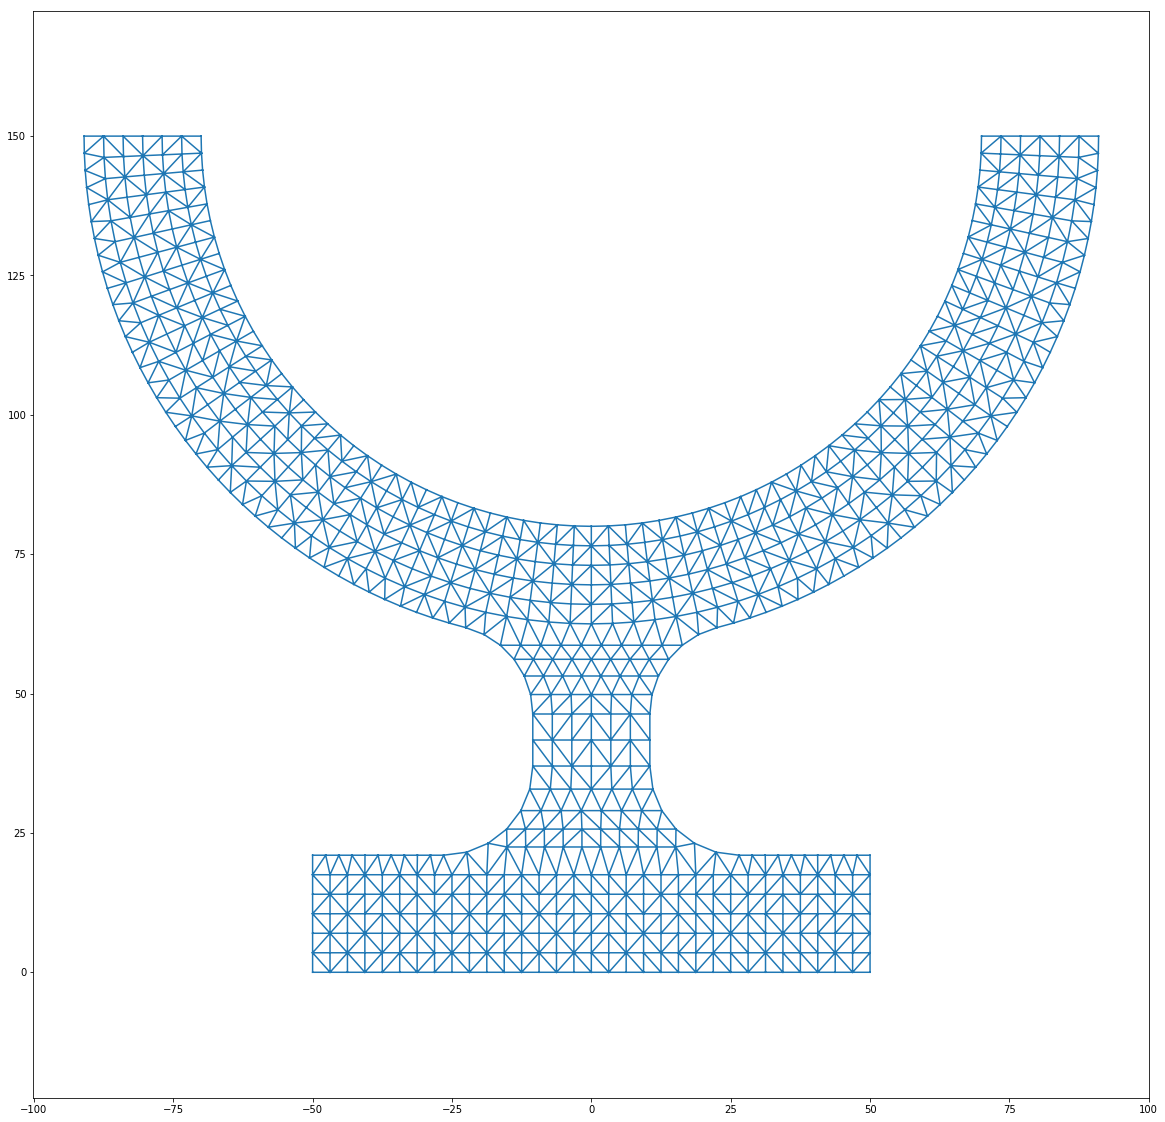

In [66]:
Nodes, simplices = construct_figure(21, 16, 3)
plt.figure(figsize=(20, 20))
plt.triplot(Nodes[:, 0], Nodes[:, 1], simplices)
plt.axis('equal')

In [14]:
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [15]:
def figure_area(Nodes, simplices):
    trng_vertices = Nodes[simplices]
    return np.sum(triarea(trng_vertices[:,0], trng_vertices[:,1], trng_vertices[:,2]))

In [26]:
def upper_small_circle_center_y(W, R):
    touch_point_x, touch_point_y, small_circle_center_y = calculate_upper_smaller_circle_y_and_touch_point(R, W, RR)
    return small_circle_center_y

In [71]:
# R>10
# H>10
# upper_small_circle_center_y > W+R
def inside_odz(W, R):
    small_circle_y = upper_small_circle_center_y(W, R)
    mask1 = (W>=10.) & (R>=10.)
    mask2 = small_circle_y > W + R
    
    return mask1 & mask2

In [72]:
import numpy.random as npr

In [77]:
#x = npr.rand(20,20)*L+1
#y = npr.rand(20,20)*H+1
l = np.linspace(0, 100, 100)
h = np.linspace(0, 100, 100)
x, y = np.meshgrid(l, h)

In [78]:
mask = inside_odz(x, y)

Text(0, 0.5, 'R')

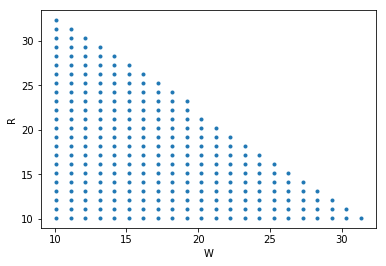

In [79]:
plt.plot(x[mask], y[mask], '.');
plt.xlabel('W')
plt.ylabel('R')

In [80]:
def sol(Nodes, simplices, constants, fixed_y, fixed_xy, forced_nodes, force_angle, debug=False):
    # Как делали на семинаре, рассчитаем:
    # 1. Матрицу градиентов B
    # 2. Глобальную матрицу жесткости
    # 3. Рассчитаем граничные условия и внесем их в МКЭ
    # 4. Рассчитаем перемещения элементов
    # 5. Найдем напряжения на элементах
    
    # -----> 1.<-----
    trng_vertices2 = Nodes[simplices] # Учитываем примененные к триангуляции маски и удалим ненужные точки
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2])
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1],0] - trng_vertices2[:,[1,2,0],0]
    z = np.zeros_like(b[:,0])
    #print(A)
    if len(A==0.0):
        if debug:
            print(">>> Array A has zero-valued triangle areas!")
            print(">>> Substituting these values with 1e-50")
        A[A == 0.0] = 1e-50
    
    zero_indexes = np.abs(A) < 1e-10
    print(zero_indexes)
    print(simplices[zero_indexes])
    
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1)
    
    # -----> 2.<-----
    coef = 1.0/(2.0*A)   
    B *= coef.reshape(-1, 1, 1)

    # Константы
    E = constants['E']   # Модуль Юнга, Н/см^2
    mu = constants['mu'] # коэффициент Ламэ, безразмерный
    t = constants['t']   # Толщина детали, cm
    P = constants['P']   # Распределенное усилие, Н/см^2
    
    D = E / (1.0 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1.0-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)

    # -----> 3.<-----
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = Nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    
    # i -- номер элемента
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    
    # fixed_xy -- граничные узлы с нулевыми перемещениями по обеим степеням свободы
    # fixed_y -- граничные узлы с нулевым перемещением по оси Y
    dof = np.hstack((fixed_xy*2, fixed_xy*2+1, fixed_y*2+1))
    
    # занулить в матрице K строки с номерами dof[i]
    # занулить в матрице K столбцы с номерами dof[i]
    # матрице K поставить 1 на диагональ в позициях (dof[i], dof[i])
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    
    # Силы, действующие на элементы
    F = np.zeros(2*Nn)
    
    # Длины ребер, к которым приложено P
    force_node_coords = Nodes[forced_nodes]
    force_areas = np.sqrt(np.sum(np.power(force_node_coords[:-1] - force_node_coords[1:], 2), axis=1))
    
    # Направление силы по осям
    direction_x = np.sign(np.cos(np.deg2rad(force_angle)))
    direction_y = np.sign(np.sin(np.deg2rad(force_angle)))
    
    # Проекции силы по осям
    forces_x = force_areas * t * P * np.sin(np.deg2rad(90 - force_angle))
    forces_y = force_areas * t * P * np.cos(np.deg2rad(90 - force_angle))
    
    # Проверка
    if not(np.all(np.sign(forces_x) == direction_x) and np.all(np.sign(forces_y) == direction_y)):
        if debug:
            print("Force direction calculation is incorrect! Thatsa bug")
        return
    
    # Внутренние точки
    #F[forced_nodes[1:-1]*2] = 0.5*forces_x[1:] + 0.5*forces_x[:-1]
    #F[forced_nodes[1:-1]*2+1] = 0.5*forces_y[1:] + 0.5*forces_y[:-1]
    
    # Граничные точки
    #F[forced_nodes[0]*2] = 0.5*forces_x[0]
    #F[forced_nodes[-1]*2] = 0.5*forces_x[-1]
    #F[forced_nodes[0]*2+1] = 0.5*forces_y[0]
    #F[forced_nodes[-1]*2+1] = 0.5*forces_y[-1]
    F[forced_nodes[1:]*2] += 0.5 * force_areas*t*P*np.cos(np.deg2rad(force_angle))
    F[forced_nodes[1:]*2+1] += 0.5 * force_areas*t*P*np.sin(np.deg2rad(force_angle))
    F[forced_nodes[:-1]*2] += 0.5 * force_areas*t*P*np.cos(np.deg2rad(force_angle))
    F[forced_nodes[:-1]*2+1] += 0.5 * force_areas*t*P*np.sin(np.deg2rad(force_angle))
    
    F[dof] = 0
    
    # -----> 4.<-----
    # решение системы линейных уравнений K*U=F
    if not np.isfinite(K).all():
        if debug:
            print('Some values of an array are infinite or nan')
            print('Cannot solve system')
        return
    
    if debug:
        print("Solving system...")
        
    print(K[0])
    print(K[1])
    
    U = np.linalg.solve(K, F)
    
    # -----> 5.<-----
    Ue = U[EFT, None]
    Eps = np.matmul(B, Ue)
    Sig = np.matmul(D, Eps)
    
    NodeA = np.zeros((Nn,1))
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.25*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    return U, NodeS1